In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score
import torch
from torch import nn

# Loading data 

In [2]:
data = pd.read_csv("../data/compas-scores-two-years.csv")

# Data processing

## Chose useful rows and columns

In [3]:
data = data.loc[data['race'].isin(['African-American','Caucasian'])]
data=data[[ 'sex','age', 'race', 'priors_count',
             'c_charge_degree', 'c_charge_desc',
             'start', 'end', 'event', 'two_year_recid']]
data = data.dropna()
data.shape

(6129, 10)

In [4]:
data.head()

,sex,age,race,priors_count,c_charge_degree,c_charge_desc,start,end,event,two_year_recid
1,Male,34,African-American,0,F,Felony Battery w/Prior Convict,9,159,1,1
2,Male,24,African-American,4,F,Possession of Cocaine,0,63,0,1
3,Male,23,African-American,1,F,Possession of Cannabis,0,1174,0,0
6,Male,41,Caucasian,14,F,Possession Burglary Tools,5,40,1,1
8,Female,39,Caucasian,0,M,Battery,2,747,0,0


## Label

In [5]:
label = data['two_year_recid']

In [6]:
sf = (data[['race']]=='Caucasian').astype(int)
sf.index = range(sf.shape[0])

## Normalize numerical columns and encode categorical columns

In [7]:
num = data._get_numeric_data()
num = num.drop(labels='two_year_recid',axis=1)
ss = StandardScaler()
num_ss = ss.fit_transform(num)
num = pd.DataFrame(num_ss,columns=num.columns)

In [8]:
num_cols = data._get_numeric_data().columns
cat = data.drop(columns = num_cols, axis = 1)
cat = cat.drop(labels='race',axis=1)
cat = pd.get_dummies(cat)
cat.index = range(cat.shape[0])

In [9]:
clean_data = pd.concat([sf,cat,num], axis=1)

# Model

## Get train, val, test sets ; transform them into tensor

In [10]:
X_train, X_test, y_train, y_test = train_test_split(clean_data,label,test_size=1/7)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=1/6)

X_train, X_val, X_test = torch.Tensor(np.array(X_train)),torch.Tensor(np.array(X_val)),torch.Tensor(np.array(X_test))
y_train, y_val, y_test = torch.Tensor(np.array(y_train)),torch.Tensor(np.array(y_val)),torch.Tensor(np.array(y_test))

## Define evaluation functions

In [11]:
def acc(pred,label):
    pred = torch.squeeze(pred).round().detach().numpy()
    label = label.detach().numpy()
    acc = (pred==label).sum() / label.shape[0]
    return acc

def calibration(pred,inp,label):
    pred_c = torch.squeeze(pred[inp[:,0]==1]).round().detach().numpy()
    pred_a = torch.squeeze(pred[inp[:,0]==0]).round().detach().numpy()
    label_c = label[inp[:,0]==1].detach().numpy()
    label_a = label[inp[:,0]==0].detach().numpy()
    acc_c = (pred_c!=label_c).sum() / label_c.shape[0]
    acc_a = (pred_a!=label_a).sum() / label_a.shape[0]
    calib = abs(acc_a-acc_c)
    return calib

def cvs(pred,inp):
    pred_c = torch.squeeze(pred[inp[:,0]==1]).round()
    pred_a = torch.squeeze(pred[inp[:,0]==0]).round()
    P_s1y1 = torch.sum(pred_c == 1)/pred_c.shape[0]
    P_s0y1 = torch.sum(pred_a == 1)/pred_a.shape[0]
    CV_score = round(torch.abs(P_s1y1 - P_s0y1).item(),4)
    return CV_score

def rate(pred,inp,label):
    pred_c = torch.squeeze(pred[inp[:,0]==1]).round().detach().numpy()
    pred_a = torch.squeeze(pred[inp[:,0]==0]).round().detach().numpy()
    label_c = label[inp[:,0]==1].detach().numpy()
    label_a = label[inp[:,0]==0].detach().numpy()
    n_c = label_c.shape[0]
    n_a = label_a.shape[0]
    cm_c = confusion_matrix(label_c,pred_c)/n_c
    cm_a = confusion_matrix(label_a,pred_a)/n_a
    fpr_c =  cm_c[0][1]
    fnr_c =  cm_c[1][0]
    fpr_a =  cm_a[0][1]
    fnr_a =  cm_a[1][0]
    fpr_diff = abs(fpr_c-fpr_a)
    fnr_diff = abs(fnr_c-fnr_a)
    return fpr_diff,fnr_diff

def nmi(pred,inp):
    mutual_info = mutual_info_score(pred.round(), inp[:,0])
    Hy = entropy(pred)
    Hs = entropy(inp[:,0])
    nmi = 2*mutual_info/(Hy+Hs)
    return nmi

## Define PR

In [12]:
class PrejudiceRemover(nn.Module):
    def __init__(self,eta):
        super().__init__()
        self.eta = eta

    def forward(self, inputs, targets):
        N = inputs.shape[0]
        N_s1 = inputs[inputs[:,0]==1].shape[0]
        N_s0 = inputs[inputs[:,0]==0].shape[0]
        
        P_ys1 = torch.sum(model(inputs[inputs[:,0]==1])) / N_s1
        P_ys0 = torch.sum(model(inputs[inputs[:,0]==0])) / N_s0
        P_y = torch.sum(model(inputs)) / N
        
        P_y1s1 = torch.log(P_ys1) - torch.log(P_y)
        P_y0s1 = torch.log(1-P_ys1) - torch.log(1-P_y)
        P_y1s0 = torch.log(P_ys0) - torch.log(P_y)
        P_y0s0 = torch.log(1-P_ys0) - torch.log(1-P_y)
        
        PI_y1s1 = torch.sum(model(inputs[inputs[:,0]==1]) * P_y1s1)
        PI_y0s1 = torch.sum((1- model(inputs[inputs[:,0]==1])) * P_y0s1)
        PI_y1s0 = torch.sum(model(inputs[inputs[:,0]==0]) * P_y1s0)
        PI_y0s0 = torch.sum((1- model(inputs[inputs[:,0]==0]))* P_y0s0)
        
        PI = PI_y1s1 + PI_y0s1 + PI_y1s0 + PI_y0s0
        
        return PI*self.eta

## Define basemodel

In [13]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

## Define evaluation data list

In [14]:
test_acc_l, val_acc_l, train_acc_l = [],[],[]
test_calib_l, val_calib_l, train_calib_l = [],[],[]
test_cvs_l, val_cvs_l, train_cvs_l = [],[],[]
test_nmi_l, val_nmi_l, train_nmi_l = [],[],[]
fpr_diff_l,fnr_diff_l = [],[]

## Train and test model to get outputs

In [16]:
model = LogisticRegression(input_dim=X_train.shape[1],output_dim=1)
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,weight_decay=1e-4)

eta = [-10,-5,-3,-1,0,1.0,2.0,3.0,5.0,10,15,20,25,30,35,40,45,50]
for e in eta:
    pr = PrejudiceRemover(e)

    Iterations = []
    iter = 0
    for epoch in range(20):
        optimizer.zero_grad() 
        outputs_train = torch.squeeze(model(X_train))
        loss_train = criterion(torch.squeeze(outputs_train), torch.tensor(np.array(y_train))) + pr.forward(X_train,y_train)
        loss_train.backward()  
        optimizer.step() 
    
        iter+=1
        if iter%1==0:
            # calculate Accuracy
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                outputs_test = torch.squeeze(model(X_test))
                loss_test = criterion(outputs_test, torch.tensor(np.array(y_test))) + pr.forward(X_test,y_test)
            
                test_acc = acc(outputs_test,y_test)
                test_calib = calibration(outputs_test,X_test,y_test)
                test_cvs = cvs(outputs_test,X_test)
                test_nmi = nmi(outputs_test,X_test)
                fpr_diff,fnr_diff = rate(outputs_test,X_test,y_test)
                
                # Calculating the loss and accuracy for the val dataset
                outputs_val = torch.squeeze(model(X_val))
                loss_val = criterion(outputs_val, torch.tensor(np.array(y_val))) + pr.forward(X_val,y_val)

                val_acc = acc(outputs_val,y_val)
                val_calib = calibration(outputs_val,X_val,y_val)
                val_cvs = cvs(outputs_val,X_val)
                val_nmi = nmi(outputs_val,X_val)
            
                # Calculating the loss and accuracy for the train dataset
                train_acc = acc(outputs_train,y_train)
                train_calib = calibration(outputs_train,X_train,y_train)
                train_cvs = cvs(outputs_train,X_train)
                train_nmi = nmi(torch.squeeze(outputs_train),X_train)
                
                Iterations.append(iter)
    
    test_acc_l.append(test_acc)
    val_acc_l.append(val_acc)
    train_acc_l.append(train_acc)
    
    test_calib_l.append(test_calib)
    val_calib_l.append(val_calib)
    train_calib_l.append(train_calib)
    
    test_cvs_l.append(test_cvs)
    val_cvs_l.append(val_cvs)
    train_cvs_l.append(train_cvs)
    
    test_nmi_l.append(test_nmi)
    val_nmi_l.append(val_nmi)
    train_nmi_l.append(train_nmi)
    
    fpr_diff_l.append(fpr_diff)
    fnr_diff_l.append(fnr_diff)

# Evaluation

## Accuracy

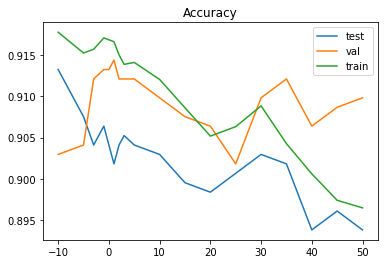

In [17]:
plt.plot(eta,test_acc_l,label='test');
plt.plot(eta,val_acc_l,label='val');
plt.plot(eta,train_acc_l,label='train');
plt.title('Accuracy')
plt.legend(loc="upper right");

## CV Score / Parity

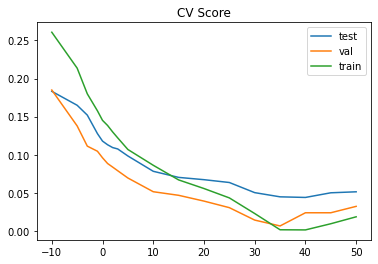

In [18]:
plt.plot(eta,test_cvs_l,label='test');
plt.plot(eta,val_cvs_l,label='val');
plt.plot(eta,train_cvs_l,label='train');
plt.title('CV Score')
plt.legend(loc="upper right");

## NMI Score

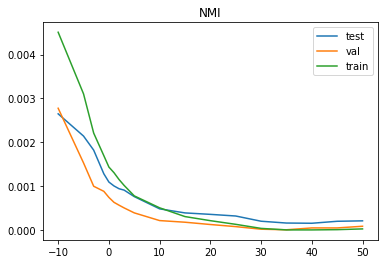

In [19]:
plt.plot(eta,test_nmi_l,label='test');
plt.plot(eta,val_nmi_l,label='val');
plt.plot(eta,train_nmi_l,label='train');
plt.title('NMI')
plt.legend(loc="upper right");

## Calibration

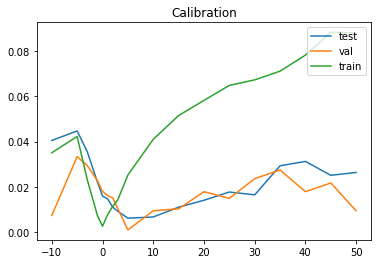

In [20]:
plt.plot(eta,test_calib_l,label='test');
plt.plot(eta,val_calib_l,label='val');
plt.plot(eta,train_calib_l,label='train');
plt.title('Calibration')
plt.legend(loc="upper right");